# DenseNet Architechture

Taken from https://github.com/andreasveit/densenet-pytorch/blob/master/densenet.py

In [1]:
import os
import time
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import LongTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps  
import cv2


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0012
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEPTH = 4 #unique to densenet

# Architecture
NUM_FEATURES = 120*100
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = True

## Loading Data

In [3]:
#loading faces
#double check that we can read them in fine

import pandas as pd
train1 = pd.read_pickle('../data/final/UScongress_train_1.pkl')
train2 = pd.read_pickle('../data/final/UScongress_train_2.pkl')
train = pd.concat([train1, train2])
valid = pd.read_pickle('../data/final/UScongress_validation.pkl')
test = pd.read_pickle('../data/final/UScongress_test.pkl')
del(train1, train2)

#change R and D to 0 and 1
train['party'] = train['party'].replace(['R', 'D'], [0, 1])
valid['party'] = valid['party'].replace(['R', 'D'], [0, 1])
test['party'] = test['party'].replace(['R', 'D'], [0, 1])

#reset indices
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [4]:
#https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
class congressDataset(Dataset):
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X, self.y[index]
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((120, 100)),
        transforms.Grayscale(1),
        transforms.ToTensor(), 
        #transforms.Normalize(0.5, 0.5)
    ])
    

#using dataset class
train_dataset = congressDataset(train['picArray'], LongTensor(train['party']))
test_dataset = congressDataset(test['picArray'], LongTensor(test['party']))
valid_dataset = congressDataset(valid['picArray'], LongTensor(valid['party']))


#loading data using torch's DataLoader function
train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)


# Checking the dataset
for images, labels in train_dl:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# # Checking the dataset
for images, labels in test_dl:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([128, 1, 120, 100])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 1, 120, 100])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_dl):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


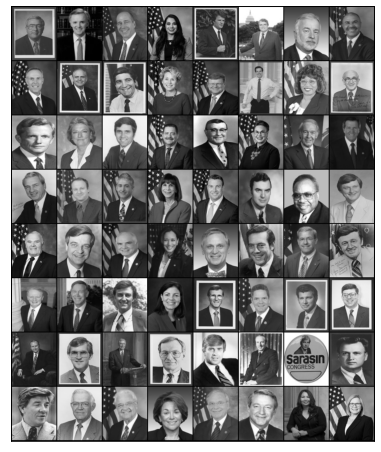

In [6]:
#just for interests sake

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

## Data Augmentation

Image batch dimensions: torch.Size([128, 1, 120, 100])
Image label dimensions: torch.Size([128])


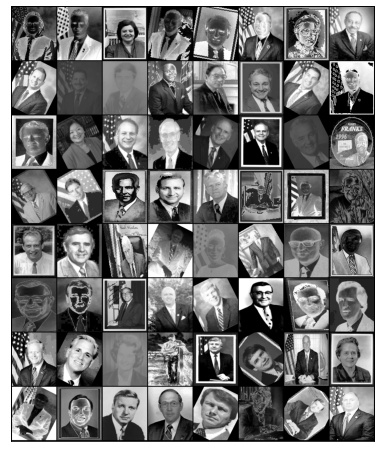

In [7]:
class congress_augmented(Dataset):
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X, self.y[index]
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((120, 100)),
        transforms.Grayscale(1),
        transforms.AutoAugment(), #new lines here
        transforms.AutoAugment(),
        #transforms.AutoAugment(), #best results with 3 autoaugment steps
        transforms.ToTensor(),
    #    transforms.Normalize(0.5, 0.5)
    ])
    

#using dataset class
train_augmented = congress_augmented(train['picArray'], LongTensor(train['party']))

#loading data using torch's DataLoader function
train_aug = DataLoader(train_augmented, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

# Checking the dataset
for images, labels in train_aug:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
show_batch(train_aug)

## Model

In [15]:
##########################
### MODEL
##########################


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3 
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(1, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 16)
        out = out.view(-1, self.in_planes)
        return self.fc(out)

In [16]:
torch.manual_seed(RANDOM_SEED)

model = DenseNet3(DEPTH, NUM_CLASSES, dropRate = 0.0)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  

### With Augmentation

In [17]:
#training
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        #logits, probas = model(features)
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

    
#main loop
train_loss = []
validation_error = []
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_aug):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        #logits, probas = model(features)
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            train_loss.append(cost.item())
            validation_error.append(compute_accuracy(model, valid_dl, device=DEVICE))
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_aug), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_aug, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/015 | Batch 0000/0012 | Cost: 0.7035
Epoch: 001/015 | Train: 50.728%
Time elapsed: 0.22 min
Epoch: 002/015 | Batch 0000/0012 | Cost: 0.6871
Epoch: 002/015 | Train: 50.728%
Time elapsed: 0.45 min
Epoch: 003/015 | Batch 0000/0012 | Cost: 0.6906
Epoch: 003/015 | Train: 50.728%
Time elapsed: 0.68 min
Epoch: 004/015 | Batch 0000/0012 | Cost: 0.6885
Epoch: 004/015 | Train: 50.662%
Time elapsed: 0.91 min
Epoch: 005/015 | Batch 0000/0012 | Cost: 0.6894
Epoch: 005/015 | Train: 51.854%
Time elapsed: 1.15 min
Epoch: 006/015 | Batch 0000/0012 | Cost: 0.6932
Epoch: 006/015 | Train: 50.199%
Time elapsed: 1.39 min
Epoch: 007/015 | Batch 0000/0012 | Cost: 0.6925
Epoch: 007/015 | Train: 50.795%
Time elapsed: 1.63 min
Epoch: 008/015 | Batch 0000/0012 | Cost: 0.6930
Epoch: 008/015 | Train: 51.854%
Time elapsed: 1.89 min
Epoch: 009/015 | Batch 0000/0012 | Cost: 0.6977
Epoch: 009/015 | Train: 50.331%
Time elapsed: 2.14 min
Epoch: 010/015 | Batch 0000/0012 | Cost: 0.6932
Epoch: 010/015 | Train: 4

In [18]:
#evaluation
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_dl, device=DEVICE)))

Test accuracy: 48.94%


In [31]:
#save train loss array
#np.save('./cost_plot/densenet.npy', train_loss)
#np.save('./cost_plot/densenet_valid.npy', validation_error)